# 06 — Predictive Classification (Supervised ML)

- E-commerce Customer Segmentation & Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix, classification_report)
from xgboost import XGBClassifier
import joblib
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

In [4]:
# Load RFM data
rfm = pd.read_csv("../data/rfm_data.csv", dtype={"CustomerID": str})

# Load train and test scaled separately
X_train_scaled = pd.read_csv("../data/rfm_train_scaled.csv", index_col=0)
X_test_scaled  = pd.read_csv("../data/rfm_test_scaled.csv", index_col=0)

print(f"RFM Shape          : {rfm.shape}")
print(f"Train Scaled Shape : {X_train_scaled.shape}")
print(f"Test Scaled Shape  : {X_test_scaled.shape}")
print("\nData loaded successfully")

RFM Shape          : (4338, 7)
Train Scaled Shape : (3470, 3)
Test Scaled Shape  : (868, 3)

Data loaded successfully


In [5]:
# KMeans fitted on training data only
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42, n_init=10)
kmeans.fit(X_train_scaled)

# Predict on full dataset
rfm_full_scaled = pd.concat([X_train_scaled, X_test_scaled]).sort_index()
rfm["KMeans_Cluster"] = kmeans.predict(rfm_full_scaled)

segment_map = {
    0: "At-Risk Customers",
    1: "Lost Customers",
    2: "Champions",
    3: "Loyal Customers"
}

rfm["Segment"] = rfm["KMeans_Cluster"].map(segment_map)

print("Segment Distribution:")
print(rfm["Segment"].value_counts())

Segment Distribution:
Segment
Lost Customers       1617
Champions            1167
At-Risk Customers     833
Loyal Customers       721
Name: count, dtype: int64


In [6]:
# Features and Targets

# Use train and test scaled as X
X_train = X_train_scaled
X_test  = X_test_scaled

# Get corresponding segments
y_full    = rfm.set_index(rfm.index)["Segment"]
y_train   = y_full.iloc[X_train.index]
y_test    = y_full.iloc[X_test.index]

le        = LabelEncoder()
le.fit(y_full)
y_train_encoded = le.transform(y_train)
y_test_encoded  = le.transform(y_test)

print(f"X_train : {X_train.shape}")
print(f"X_test  : {X_test.shape}")
print(f"Classes : {le.classes_}")

X_train : (3470, 3)
X_test  : (868, 3)
Classes : ['At-Risk Customers' 'Champions' 'Lost Customers' 'Loyal Customers']


In [7]:
# Models and Param_grid

def get_models_and_params():
    """
    Returns list of (name, estimator, param_grid) tuples for GridSearchCV
    """
    models_and_params = []

    # 1. Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr_params = {
        "C"     : [0.01, 0.1, 1, 10],
        "solver": ["lbfgs", "saga"]
    }
    models_and_params.append(("Logistic Regression", lr, lr_params))

    # 2. Random Forest
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_params = {
        "n_estimators"     : [50, 100, 200],
        "max_depth"        : [3, 4, 6, None],
        "min_samples_split": [2, 5]
    }
    models_and_params.append(("Random Forest", rf, rf_params))

    # 3. XGBoost
    xgb = XGBClassifier(random_state=42, eval_metric="mlogloss")
    xgb_params = {
        "n_estimators" : [50, 100, 200],
        "max_depth"    : [3, 4, 6],
        "learning_rate": [0.01, 0.1, 0.2]
    }
    models_and_params.append(("XGBoost", xgb, xgb_params))

    return models_and_params

In [8]:
# Train and select model

def train_and_select_model(X_train, y_train, cv=5, scoring="f1_weighted"):
    """
    Trains all models using GridSearchCV
    Returns tuned models, best params and best CV scores
    """
    models_and_params = get_models_and_params()

    tuned_models   = {}
    best_params    = {}
    best_cv_scores = {}

    for name, model, params in models_and_params:
        print(f"Tuning {name}...")

        grid = GridSearchCV(
            model,
            params,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        tuned_models[name]   = grid.best_estimator_
        best_params[name]    = grid.best_params_
        best_cv_scores[name] = round(grid.best_score_, 4)

        print(f"{name} — Best CV F1: {best_cv_scores[name]}")

    return tuned_models, best_params, best_cv_scores

In [9]:
tuned_models, best_params, best_cv_scores = train_and_select_model(
    X_train,
    y_train_encoded,
    cv=5,
    scoring="f1_weighted"
)

print("\nAll models tuned successfully")

Tuning Logistic Regression...
Logistic Regression — Best CV F1: 0.9931
Tuning Random Forest...
Random Forest — Best CV F1: 0.9741
Tuning XGBoost...
XGBoost — Best CV F1: 0.9775

All models tuned successfully


In [10]:
# Evaluation All models

def evaluate_models(tuned_models, X_test, y_test):
    """
    Evaluates all tuned models and returns results dataframe
    """
    results = {}

    for name, model in tuned_models.items():
        y_pred = model.predict(X_test)
        results[name] = {
            "Accuracy" : round(accuracy_score(y_test, y_pred), 4),
            "F1 Score" : round(f1_score(y_test, y_pred, average="weighted"), 4),
            "Precision": round(precision_score(y_test, y_pred, average="weighted"), 4),
            "Recall"   : round(recall_score(y_test, y_pred, average="weighted"), 4)
        }

    return pd.DataFrame(results).T

results_df = evaluate_models(tuned_models, X_test, y_test_encoded)
print("Model Evaluation Results:")
results_df

Model Evaluation Results:


,Accuracy,F1 Score,Precision,Recall
Logistic Regression,0.9965,0.9965,0.9966,0.9965
Random Forest,0.9862,0.9861,0.9862,0.9862
XGBoost,0.9827,0.9827,0.9827,0.9827


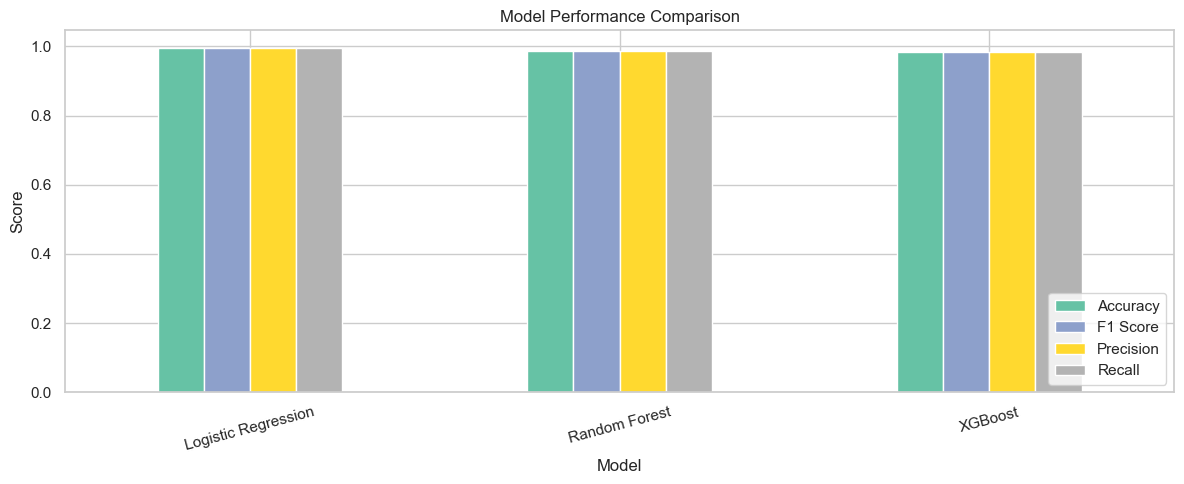

In [11]:
# Model Comparison Bar Chart

results_df[["Accuracy", "F1 Score", "Precision", "Recall"]].plot(
    kind="bar",
    figsize=(12, 5),
    colormap="Set2"
)
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [12]:
# Classification Report 

def get_best_model(results_df, tuned_models):
    """
    Returns best model name and estimator based on F1 Score
    """
    best_name  = results_df["F1 Score"].idxmax()
    best_model = tuned_models[best_name]
    return best_name, best_model

best_name, best_model = get_best_model(results_df, tuned_models)
y_pred_best = best_model.predict(X_test)

print(f"Best Model : {best_name}")
print(classification_report(y_test_encoded, y_pred_best, target_names=le.classes_))

Best Model : Logistic Regression
                   precision    recall  f1-score   support

At-Risk Customers       1.00      0.98      0.99       166
        Champions       1.00      1.00      1.00       231
   Lost Customers       0.99      1.00      1.00       321
  Loyal Customers       1.00      1.00      1.00       150

         accuracy                           1.00       868
        macro avg       1.00      1.00      1.00       868
     weighted avg       1.00      1.00      1.00       868



In [13]:
#  Retrain Best Model on Full Dataset

# Full dataset = train + test combined
X_full = pd.concat([X_train_scaled, X_test_scaled]).sort_index()
y_full_encoded = le.transform(rfm["Segment"])


print(f"Retraining {best_name} on full dataset...")

# Recreate model with best params from GridSearchCV
if best_name == "Logistic Regression":
    final_model = LogisticRegression(
        **best_params[best_name],
        max_iter=1000,
        random_state=42
    )
elif best_name == "Random Forest":
    final_model = RandomForestClassifier(
        **best_params[best_name],
        random_state=42,
        n_jobs=-1
    )
elif best_name == "XGBoost":
    final_model = XGBClassifier(
        **best_params[best_name],
        random_state=42,
        eval_metric="mlogloss"
    )

# Train on FULL dataset
final_model.fit(X_full, y_full_encoded)
print(f" {best_name} retrained on full dataset ({X_full.shape[0]} customers)")

Retraining Logistic Regression on full dataset...
 Logistic Regression retrained on full dataset (4338 customers)


In [14]:
# Sanity check

y_pred_full = final_model.predict(X_full)
print(f"Full Data Accuracy : {accuracy_score(y_full_encoded, y_pred_full):.4f}")
print(f"Full Data F1 Score : {f1_score(y_full_encoded, y_pred_full, average='weighted'):.4f}")
print("Note: In-sample score — expected to be high")

Full Data Accuracy : 0.9963
Full Data F1 Score : 0.9963
Note: In-sample score — expected to be high


In [15]:
def cross_validate_models(tuned_models, X, y_encoded, cv=5):
    """
    Performs cross validation on all tuned models
    """
    cv_results = {}

    for name, model in tuned_models.items():
        cv_score = cross_val_score(
            model, X, y_encoded,
            cv=cv,
            scoring="f1_weighted"
        )
        cv_results[name] = {
            "Mean CV F1": round(cv_score.mean(), 4),
            "Std CV F1" : round(cv_score.std(), 4)
        }

    return pd.DataFrame(cv_results).T

cv_df = cross_validate_models(tuned_models, X_full, y_full_encoded)
print("Cross Validation Results (5-Fold):")
cv_df

Cross Validation Results (5-Fold):


,Mean CV F1,Std CV F1
Logistic Regression,0.9938,0.0019
Random Forest,0.9753,0.0036
XGBoost,0.9786,0.0053


In [16]:
# Summary


print("PREDICTION SUMMARY\n")

print(f"\nBest Model    : {best_name}")
print(f"Accuracy      : {results_df.loc[best_name, 'Accuracy']}")
print(f"F1 Score      : {results_df.loc[best_name, 'F1 Score']}")
print(f"Precision     : {results_df.loc[best_name, 'Precision']}")
print(f"Recall        : {results_df.loc[best_name, 'Recall']}")
print(f"\nAll Model Results:")
print(results_df.to_string())
print(f"\nCross Validation Results:")
print(cv_df.to_string())

print("\n\nProject complete!")

PREDICTION SUMMARY


Best Model    : Logistic Regression
Accuracy      : 0.9965
F1 Score      : 0.9965
Precision     : 0.9966
Recall        : 0.9965

All Model Results:
                     Accuracy  F1 Score  Precision  Recall
Logistic Regression    0.9965    0.9965     0.9966  0.9965
Random Forest          0.9862    0.9861     0.9862  0.9862
XGBoost                0.9827    0.9827     0.9827  0.9827

Cross Validation Results:
                     Mean CV F1  Std CV F1
Logistic Regression      0.9938     0.0019
Random Forest            0.9753     0.0036
XGBoost                  0.9786     0.0053


Project complete!
